In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import get_velocity_profile, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
def mw_stellar_surface_density_profile(radius):
    sigma_0_thin = 1115e6
    sigma_0_thick = 300e6
    rs_thin = 2.5
    rs_thick = 2.0
    return sigma_0_thin * np.exp(-radius / rs_thin) + sigma_0_thick * np.exp(-radius / rs_thick)

def mw_gas_density_profile(radius, sigma_g_0 = 1.40e8, rs = 3.75):
    return sigma_g_0 * np.exp(-radius / rs)

def mendezdelgado2022_profile(xlim = [0, 15]):
    radii = np.linspace(xlim[0], xlim[1], 1000)
#     oh = [np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) /
#                    vice.solar_z['o']) - 0.059 * r for r in radii]
    log_oh_plus12 = [9.22 - 0.059 * r for r in radii]
    return [radii, log_oh_plus12]

In [32]:
# output = vice.output("../outputs/expifr/amd/betaphiin0p8")
# output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/prograde")
# output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/radial")
# output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin-0p8")

# output = vice.output("../outputs/expifr/amd/base")
output = vice.output("../outputs/expifr_gse/amd-pwd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p2")
extra = np.genfromtxt("%s_analogdata.out" % (output.name))
output.stars["absz"] = [abs(_) for _ in extra[:, -1][:output.stars.size[0]]]

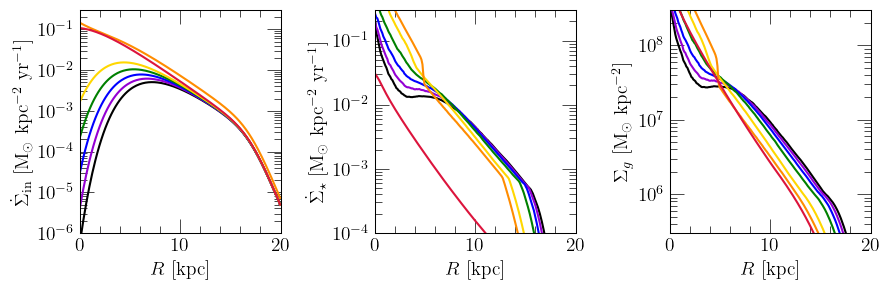

In [33]:
LOOKBACKS = [0, 2, 4, 6, 8, 10, 12.2]
# LOOKBACKS = [9.4, 9.6, 9.8, 10, 10.2, 10.4, 10.6]
COLORS = ["black", "darkviolet", "blue", "green", "gold", "darkorange", "crimson"]
# LOOKBACKS = [11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

fig = plt.figure(figsize = (9, 3))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"$R$ [kpc]")
    axes[i].set_yscale("log")
    axes[i].set_xlim([0, 20])
axes[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[2].set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
axes[0].set_ylim([1.e-6, 0.3])
axes[1].set_ylim([1.0e-4, 0.3])
axes[2].set_ylim([3.0e5, 3.0e8])

def plot_snapshot(ax_ifr, ax_sfr, ax_gas, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    sigma_ifr = []
    sigma_sfr = []
    sigma_gas = []
    for i in range(len(output.zones.keys())):
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    ax_ifr.plot(radii, sigma_ifr, **kwargs)
    ax_sfr.plot(radii, sigma_sfr, **kwargs)
    ax_gas.plot(radii, sigma_gas, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    plot_snapshot(*axes, output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./calibration/basemodel-evol.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-prograde-evol.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-radial-evol.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-retrograde-evol.%s" % (ext), **kwargs)
plt.show()

In [38]:
# for i in range(len(output.zones.keys())):
#     zone_width = 0.1
#     zone = output.zones["zone%d" % (i)]
#     mgas = zone.history["mgas"][-1]
#     sfr = zone.history["sfr"][-1] * 1.0e9
#     taustar = mgas / sfr
#     radius = zone_width * (i + 0.5)
#     print(radius, taustar)

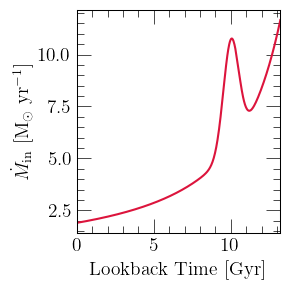

In [29]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_ylabel(r"$\dot M_\text{in}$ [M$_\odot$ yr$^{-1}$]")
# ax.set_ylabel(r"[O/H]")
# ax.set_ylabel(r"$\dot M_\star$ at $R = 8$ kpc [M$_\odot$ yr$^{-1}$]")
ax.set_xlim([0, 13.2])
# ax.set_ylim([0, 0.08])
# ax.set_yscale("log")
# ax.set_ylim([-1.5, 0])

def plot_evol(output, zone_width = 0.1, **kwargs):
    lookback = output.zones["zone0"].history["lookback"]
    ifr = []
    for i in range(len(lookback)):
        tot = 0
        for j in range(len(output.zones.keys())):
            tot += output.zones["zone%d" % (j)].history["ifr"][i]
        ifr.append(tot)
    ax.plot(lookback, ifr, **kwargs)

    # zone = int(radius / zone_width)
    # zone = output.zones["zone%d" % (zone)]
    # # ax.plot(zone.history["lookback"], zone.history["sfr"], **kwargs)
    # ax.plot(zone.history["lookback"], zone.history["ifr"], **kwargs)
    # ax.plot(zone.history["lookback"], zone.history["[o/h]"], **kwargs)

plot_evol(output, 8, c = named_colors()["crimson"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./calibration/basemodel-sfh8kpc.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-prograde-sfh8kpc.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-radial-sfh8kpc.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-retrograde-sfh8kpc.%s" % (ext), **kwargs)
plt.show()

5.436e+10
9.039e+09


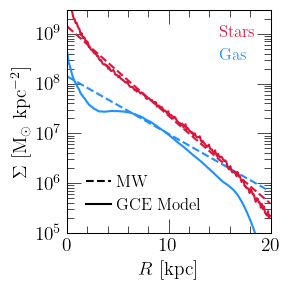

In [34]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"$\Sigma$ [M$_\odot$ kpc$^{-2}$]")
ax.set_xlim([0, 20])
ax.set_ylim([1.0e5, 3.0e9])
ax.set_yscale("log")

radii = [0.1 * (i + 0.5) for i in range(200)]
target = [mw_stellar_surface_density_profile(r) for r in radii]
ax.plot(radii, target, c = named_colors()["crimson"], linestyle = "--")
target = [mw_gas_density_profile(r) for r in radii]
ax.plot(radii, target, c = named_colors()["dodgerblue"], linestyle = "--")

kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--",
    "label": "MW"
}
line1 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs["linestyle"] = "-"
kwargs["label"] = "GCE Model"
line2 = ax.plot([1, 2], [1, 2], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "handlelength": 1.5,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
ax.add_artist(leg)
line1.remove()
line2.remove()

def plot_results(output, zone_width = 0.1, which = "stars", **kwargs):
    radii = []
    sigma = []
    mass = 0
    for i in range(len(output.zones.keys())):
        radii.append(zone_width * (i + 0.5))
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        if which == "stars":
            m = output.zones["zone%d" % (i)].history["mstar"][-1]
        elif which == "gas":
            m = output.zones["zone%d" % (i)].history["mgas"][-1]
        else:
            raise ValueError("Bruh")
        sigma.append(m / area)
        mass += m
    print("%.3e" % (mass))
    ax.plot(radii, sigma, **kwargs)

plot_results(output, c = named_colors()["crimson"], label = "Stars")
plot_results(output, which = "gas", c = named_colors()["dodgerblue"], label = "Gas")

# ax.axhline(1.0e7, c = named_colors()["black"])

kwargs = {
    "loc": mpl_loc("upper right"),
    # "bbox_to_anchor": (0.02, 0.22),
    "handlelength": 0,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "dodgerblue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./calibration/basemodel-surfacedensities.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-prograde-surfacedensities.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-radial-surfacedensities.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-retrograde-surfacedensities.%s" % (ext), **kwargs)
plt.show()

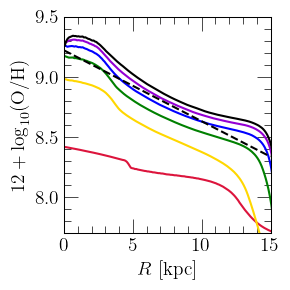

In [35]:
LOOKBACKS = [10, 8, 6, 4, 2, 0]
COLORS = ["crimson", "gold", "green", "blue", "darkviolet", "black"]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"$12 + \log_{10}$(O/H)")
ax.set_xlim([0, 15])
ax.set_ylim([7.7, 9.5])

def plot_predicted_metallicity_profile(output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    oh = []
    for i in range(len(radii)):
        oh.append(oh_to_12pluslog(output.zones["zone%d" % (i)].history["[o/h]"][idx]))
    ax.plot(radii, oh, **kwargs)

def plot_observed_metallicity_profile(**kwargs):
    radii, oh = mendezdelgado2022_profile()
    ax.plot(radii, oh, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g$ Gyr ago" % (LOOKBACKS[i])
    }
    plot_predicted_metallicity_profile(output, LOOKBACKS[i], **kwargs)
plot_observed_metallicity_profile(c = named_colors()["black"], linestyle = "--")

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./calibration/basemodel-ohismsnapshots.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-prograde-ohismsnapshots.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-radial-ohismsnapshots.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-retrograde-ohismsnapshots.%s" % (ext), **kwargs)
plt.show()

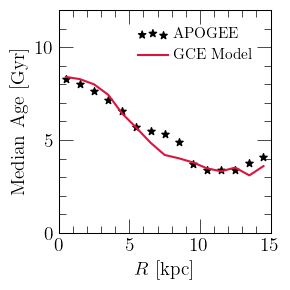

In [36]:
fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"Median Age [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 12])
ax.set_yticks([0, 5, 10])

def plot_data(ax, filename = "./apogee-astronn-ageprofile.out", **kwargs):
    raw = np.genfromtxt(filename)
    radii = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
    age = raw[:, 3]
    ax.scatter(radii, age, **kwargs)

def plot_prediction(ax, output, zone_width = 0.1, **kwargs):
    n_zones = len(output.zones.keys())
    # radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    radii = list(range(16))
    ages = []
    for i in range(len(radii) - 1):
        # sys.stdout.write("\ri = %d
        inner = int(radii[i] / zone_width)
        outer = int(radii[i + 1] / zone_width) + 1
        stars = output.stars.filter(
            "zone_final", ">=", inner).filter(
            "zone_final", "<", outer).filter(
            "absz", "<=", 0.5).filter(
            "mass", ">", 1)
        ages.append(weighted_median(stars["age"], stars["mass"]))
    radii = [(a + b) / 2 for a, b in zip(radii[:-1], radii[1:])]
    ax.plot(radii, ages, **kwargs)

plot_data(ax, c = named_colors()["black"], marker = markers()["star"], s = 30, label = "APOGEE")
plot_prediction(ax, output, c = named_colors()["crimson"], label = "GCE Model")

kwargs = {
    "loc": mpl_loc("upper right"),
    "bbox_to_anchor": (0.98, 0.98),
    "fontsize": 11
}
leg = ax.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./calibration/basemodel-ageprofile.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-prograde-ageprofile.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-radial-ageprofile.%s" % (ext), **kwargs)
    # plt.savefig("./calibration/tacc3p2-retrograde-ageprofile.%s" % (ext), **kwargs)
plt.show()

In [9]:
def tot_mgas(name, lookback):
    out = vice.output(name)
    diff = [abs(_ - lookback) for _ in out.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    mgas = 0
    for i in range(len(out.zones.keys())):
        mgas += out.zones["zone%d" % (i)].history["mgas"][idx]
    return mgas

def tot_infall(name):
    out = vice.output(name)
    dt = out.zones["zone0"].history["time"][1] - out.zones["zone0"].history["time"][0]
    infall = 0
    for i in range(len(out.zones.keys())):
        zone = out.zones["zone%d" % (i)]
        for j in range(len(zone.history["time"])):
            infall += zone.history["ifr"][j] * dt * 1.0e9
    return infall

without = tot_infall("../outputs/expifr/amd/base")
with_ = tot_infall("../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")
print("%.3e Msun" % (with_))
print("%.3e Msun" % (without))
print("%.3e Musn" % (with_ - without))

# without = tot_mgas("../outputs/expifr/amd_betaphiin0p8", 0)
# with_ = tot_mgas("../outputs/expifr_gse/massratio3-tacc3p2-metalpoorgse-expsigma", 0)
# print("%.3e Msun" % (with_))
# print("%.3e Msun" % (without))
# print("%.3e Msun" % (with_ - without))

6.343e+10 Msun
5.686e+10 Msun
6.566e+09 Musn


ValueError: x and y must have same first dimension, but have shapes (120,) and (0,)

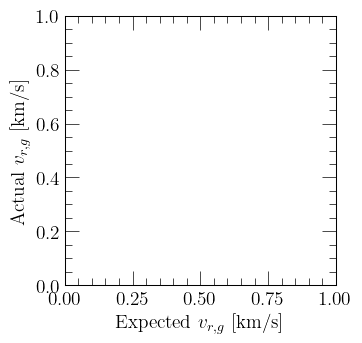

In [6]:
# LOOKBACKS = [0, 2, 4, 6, 8, 10]
# COLORS = ["black", "darkviolet", "blue", "green", "gold", "crimson"]
LOOKBACKS = [0]
COLORS = ["black"]

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Expected $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Actual $v_{r,g}$ [km/s]")
# ax.set_xlim([-4, 0])
# ax.set_ylim(ax.get_xlim())

def expected_velocities(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    velocities = []
    for i in range(len(output.zones.keys())):
        radius = zone_width * (i + 0.5)
        zone = output.zones["zone%d" % (i)]
        v = zone.history["ofr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_out)
        v -= zone.history["ifr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_in)
        v *= radius
        velocities.append(v)
    return velocities

def plot_predictions(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1, **kwargs):
    expected = expected_velocities(output, lookback,
        v_circ_ratio_in = v_circ_ratio_in,
        v_circ_ratio_out = v_circ_ratio_out,
        zone_width = zone_width)
    radii, actual = get_velocity_profile(output, lookback)
    # for i in range(len(radii)):
    #     if abs(radii[i] / actual[i] - 1) > 1: print(i)
    # for i in range(len(radii)):
    #     print(radii[i], expected[i], actual[i])
    # ax.plot(expected[110:120], actual[110:120], **kwargs)
    ax.plot(expected[30:150], actual[30:150], **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"%g Gyr ago" % (LOOKBACKS[i])
    }
    plot_predictions(output, LOOKBACKS[i], **kwargs)

# ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), c = named_colors()["black"], linestyle = "--")
plt.tight_layout()
plt.show()